In [137]:
# basic imports 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [138]:
#nltk
#use this for preprocessing 
import nltk.classify.util
from nltk.corpus import stopwords   # remove stopwords from the text 
from nltk.tokenize import word_tokenize # split the words
from nltk.corpus import wordnet  # finding similar opposite of words # finding meaning out of the words
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# text blob
from textblob import TextBlob # use this for sentiment analysis - polarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.metrics as metrics

#split the data
from sklearn.model_selection import train_test_split

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import joblib

In [139]:
# import data
df = pd.read_excel("E:/BA 360/Case Studies & Assignments/Python Projects/5. Bank Reviews-Complaints Analysis/BankReviews.xlsx")

In [140]:
# remove date column
df = df[df.columns.difference(['Date'])]

### Pre-Processing

In [141]:
def pre_process(sentence):
    ## clean text
    expression = re.compile(r'[^\w\s_]')
    cleaned_sentence = re.sub(expression,"",sentence)
    cleaned_sentence = re.sub('[\\n\\r]',"",cleaned_sentence)
    
    # tokenization and remove punctuations
    List_of_words = gensim.utils.simple_preprocess(str(cleaned_sentence),
                                                   deacc=True , min_len= 3) # deacc=True removes punctuations
                                                                            # min_len will remove all token less than 3
    
    return List_of_words

In [142]:
# Apply preprocessing on 'Reviews' column to get list of clean words
df["Reviews"] = df.Reviews.apply(lambda x: pre_process(x))
print(df.Reviews[0])

['great', 'job', 'wyndham', 'capital', 'each', 'person', 'was', 'professional', 'and', 'helped', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'thank', 'you']


In [143]:
# creating bigrams/tri-grams models using gensim
bigram = gensim.models.Phrases(df.Reviews, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df.Reviews], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#showing example of bigram
print(trigram_mod[df.Reviews[2]])

['had', 'past', 'experience', 'with', 'wyndham', 'mortgage', 'and', 'would', 'without', 'question', 'use', 'again', 'and', 'again', 'needed', 'wyndham', 'went', 'beyond', 'the', 'extra', 'mile', 'not_only', 'right', 'wrong', 'encountered', 'from', 'the', 'servicer', 'were', 'dealing', 'our', 'previous', 'loan', 'but', 'they', 'pulled', 'together', 'and', 'found', 'viable', 'option', 'for', 'that', 'ultimately', 'saved', 'money', 'would', 'highly_recommend', 'brad', 'thomka', 'and', 'the', 'wyndham_capital', 'mortgage', 'team', 'for', 'your', 'mortgage', 'needs', 'sincerest', 'thanks', 'wyndham', 'lind']


In [144]:
# REMOVE STOPWORDS , MAKE BIGRAMS/ TRIGRAMS & LEMMATIZATION

# Stopwords Preparation
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use' ,'us','bank','would']) #extend the list with some new words

def remove_stopwords(List_of_words):
    return [word for word in List_of_words if word not in stop_words]

def make_bigrams(doc):
    return bigram_mod[doc]

def make_trigrams(doc):
    return trigram_mod[bigram_mod[doc]]


# apply to the review columns
df['Reviews_cleaned'] = df.Reviews.apply(lambda x: remove_stopwords(x))
df['Reviews_cleaned'] = df.Reviews_cleaned.apply(lambda x: make_bigrams(x))
df['Reviews_cleaned'] = df.Reviews_cleaned.apply(lambda x: make_trigrams(x))

In [145]:
# showing comparison of a document after adding bigrams/trigrams & removing stopwords

print("Doc Before\n"  ,df.Reviews[5])
print("\n------------")
print("Doc After\n"  ,df.Reviews_cleaned[5])

Doc Before
 ['had', 'the', 'pleasure', 'working', 'with', 'wyndham', 'capital', 'september', 'family', 'and', 'were', 'making', 'home', 'purchase', 'columbus', 'from', 'the', 'original', 'conversation', 'with', 'the', 'loan', 'officer', 'underwriting', 'and', 'all', 'the', 'way', 'through', 'closing', 'the', 'entire', 'team', 'from', 'wyndham', 'was', 'very', 'responsive', 'and', 'professional', 'was', 'very', 'impressed', 'with', 'how', 'smooth', 'their', 'process', 'was', 'and', 'how', 'timely', 'the', 'communication', 'was', 'given', 'how', 'stressful', 'process', 'home', 'buying', 'and', 'selling', 'can']

------------
Doc After
 ['pleasure_working', 'wyndham_capital', 'september', 'family', 'making', 'home_purchase', 'columbus', 'original', 'conversation', 'loan_officer', 'underwriting', 'way', 'closing', 'entire', 'team', 'wyndham', 'responsive', 'professional', 'impressed', 'smooth', 'process', 'timely', 'communication', 'given', 'stressful', 'process', 'home_buying', 'selling']

## 1. Sentiment Analysis

In [146]:
#show sentiment based on reviews
def sentiment_score(List):
    text = " ".join([word for word in List])
    Sentiment_Score = TextBlob(text).sentiment.polarity
    return Sentiment_Score

def sentiment_type(Score):
    if Score > 0.05:
        Sentiment_Cat = 'Positive'
    elif Score < 0:
        Sentiment_Cat = 'Negative'
    else:Sentiment_Cat = 'Neutral'
    
    return Sentiment_Cat

In [147]:
df['Sentiment_Score'] =  df.Reviews_cleaned.apply(lambda x: sentiment_score(x))
df['Sentiment_Type'] =  df.Sentiment_Score.apply(lambda x: sentiment_type(x))

In [148]:
df[["Reviews_cleaned","Sentiment_Score","Sentiment_Type"]].head()

,Reviews_cleaned,Sentiment_Score,Sentiment_Type
0,"[great_job, wyndham_capital, person, professio...",0.250000,Positive
1,"[matthew, richardson, professional, helpful, h...",0.550000,Positive
2,"[past, experience, wyndham, mortgage, without,...",-0.071825,Negative
3,"[dealing, brad, thomka, beginning, started, st...",0.056548,Positive
4,"[cant, express, grateful, support, zach, provi...",0.100000,Positive


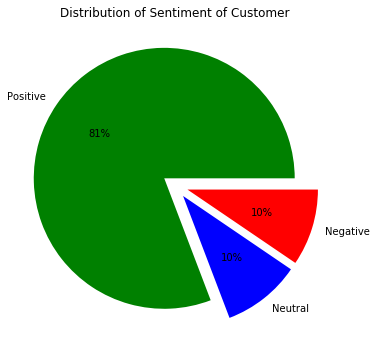

In [149]:
plt.figure(figsize = (6,6))
plt.title("Distribution of Sentiment of Customer")
plt.pie(df.Sentiment_Type.value_counts(), labels = df.Sentiment_Type.value_counts().index,colors = ['g','b','r'] ,
        autopct='%1.0f%%', explode=[0.1]*3)
plt.show()

In [150]:
pd.crosstab(df.Sentiment_Type,df.BankName).T

Sentiment_Type,Negative,Neutral,Positive
BankName,,,
Guarenteed Rate Inc,12,5,64
LoanSnap,0,1,39
North American Savings Bank,23,19,151
Pacific Beneficial Mortgage Co,1,7,43
Reliance First Capital,10,14,34
Triumph Lending,1,3,56
Wyndham Capital Mortgage,1,0,21


### Key Positive/ Negative words

In [151]:
# find positive negative words in each review
def postive_words(words):
    list_pos = []
    for word in words:
        polarity = TextBlob(word).sentiment.polarity
        if polarity > 0:
            list_pos.append(word)
    return list_pos

def negative_words(words):
    list_neg = []
    for word in words:
        polarity = TextBlob(word).sentiment.polarity
        if polarity < 0:
            list_neg.append(word)
    return list_neg


df['Positive_words'] = df['Reviews_cleaned'].apply(postive_words)
df['Negative_words'] = df['Reviews_cleaned'].apply(negative_words)

In [152]:
df.iloc[:,4:].head()

,Sentiment_Score,Sentiment_Type,Positive_words,Negative_words
0,0.250000,Positive,"[professional, smoothly]",[]
1,0.550000,Positive,"[professional, much, excellent]",[]
2,-0.071825,Negative,"[right, thanks]","[past, wrong, previous]"
3,0.056548,Positive,"[happy, right, thanks]","[wrong, previous, less]"
4,0.100000,Positive,[professional],[]


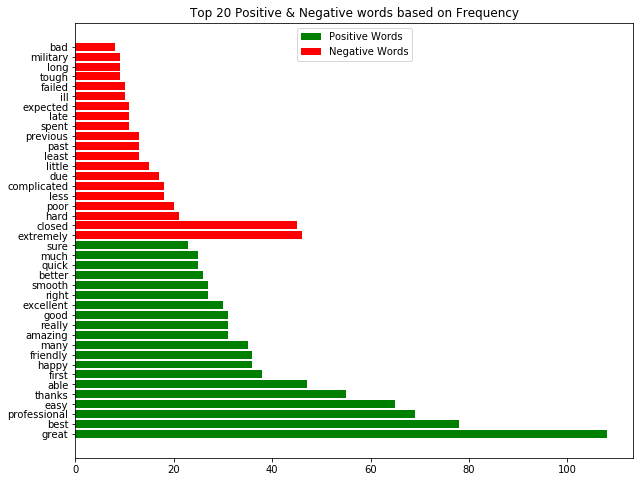

In [153]:
#### get list of positive and negative words in whole dataset
Pos_words = list()
Neg_words = list()

# divide all the words into positive and negative lists
for row in range(len(df)):
    current_pos = df.Positive_words[row]
    current_neg = df.Negative_words[row]
    if len(current_pos) > 0:
        for word in current_pos:
            Pos_words.append(word)
    if len(current_neg) > 0:
        for word in current_neg:
            Neg_words.append(word)
            

# convert each lists into frequency table 
Pos_table = pd.Series(Pos_words).value_counts().reset_index()
Neg_table = pd.Series(Neg_words).value_counts().reset_index()
Pos_table.columns = ['word','frequency']
Neg_table.columns = ['word','frequency']

#sort by frequency
Pos_table.sort_values(by='frequency',ascending =False, inplace = True)
Neg_table.sort_values(by='frequency',ascending =False, inplace = True)

plt.figure(figsize =(10,8))
plt.title("Top 20 Positive & Negative words based on Frequency")
plt.barh(Pos_table.head(20).word,Pos_table.head(20).frequency,color = 'green' , label = 'Positive Words' )
plt.barh(Neg_table.head(20).word,Neg_table.head(20).frequency,color = 'red' , label = 'Negative Words' )
plt.legend(loc = 'upper center')
plt.show()

##### Wordclouds

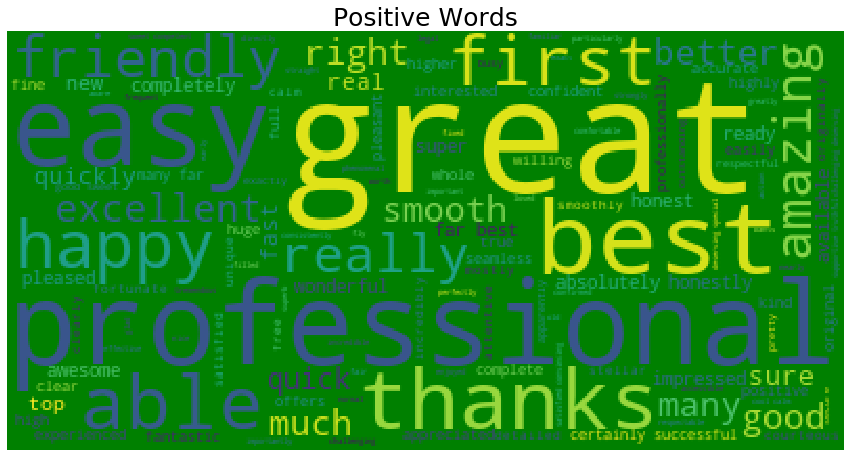

In [154]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

wordcloud_p = WordCloud(background_color='green', stopwords=set(stopwords.words('english')))

wordcloud_p = wordcloud_p.generate(' '.join([word for word in Pos_words]))

%matplotlib inline
fig = plt.figure(figsize=(15, 12))
plt.axis('off')
plt.title('Positive Words',fontdict={'fontsize':25})
plt.imshow(wordcloud_p)
plt.show()

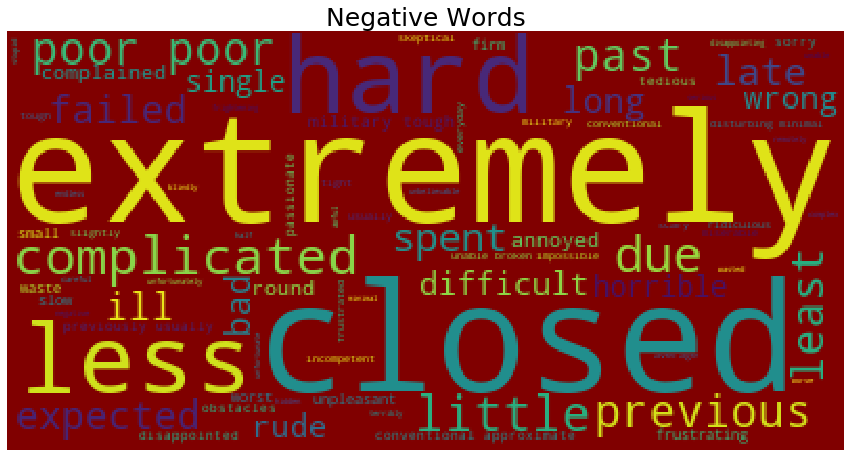

In [155]:
wordcloud_n = WordCloud(background_color='maroon', stopwords=set(stopwords.words('english')))

wordcloud_n = wordcloud_n.generate(' '.join([word for word in Neg_words]))

%matplotlib inline

fig = plt.figure(figsize=(15, 12))
plt.axis('off')
plt.title('Negative Words',fontdict={'fontsize':25})
plt.imshow(wordcloud_n)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------------
## 2. Classification of reviews into positive ,negative and neutral 

###### Define train-test data

In [156]:
# convert document list into text
def convert_totext(List):
    text = " ".join([word for word in List])
    return text

In [218]:
#define X and y
X = df.Reviews_cleaned.apply(convert_totext)

y = df.Sentiment_Type  # negative, positive and neutral

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 ,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(353,)
(152,)
(353,)
(152,)


###### feature creation through  document term matrix of train n test data

In [219]:
#Train
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(X_train)
#test
X_test_tfidf = tfidf_vect.transform(X_test)
X_test_count = count_vect.transform(X_test)
dtm_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
dtm_count = pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())

In [220]:
dtm_tfidf.head()

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,...,year,years,yelp,yep,yes,yet,youre,zach,zelada,zero
0,0.0,0.0,0.0,0.109909,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.114988,0.0,0.0,...,0.0,0.07854,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.318683,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [221]:
dtm_tfidf.shape

(353, 2313)

* data has 2313 feautures

###### UDF to apply different model and predicting respective model scores
Note: the following function will be used throughout the study for comparing different models

In [222]:
def model_score(model_function, vect = "tfidf"):
    if vect == 'tfidf':
        X_tr = X_train_tfidf
        X_ts = X_test_tfidf
    elif vect == 'count':
        X_tr = X_train_count
        X_ts = X_test_count
    #the function assumes labels named as y_test & y_train: hence no need to input them as an argument 
    model = model_function
    model = model.fit(X_tr,y_train)
    
    return [metrics.accuracy_score( y_train ,model.predict(X_tr)),metrics.accuracy_score( y_test ,model.predict(X_ts)), model]

###### model building on tfidf term matrix

In [223]:
# naive bayes
nb_tfidf = model_score(MultinomialNB(),vect='tfidf')
#Random Forest
rf_tfidf = model_score(RandomForestClassifier())
#adaboost
ada_tfidf = model_score(AdaBoostClassifier())
#neural network
mlp_tfidf = model_score(MLPClassifier())

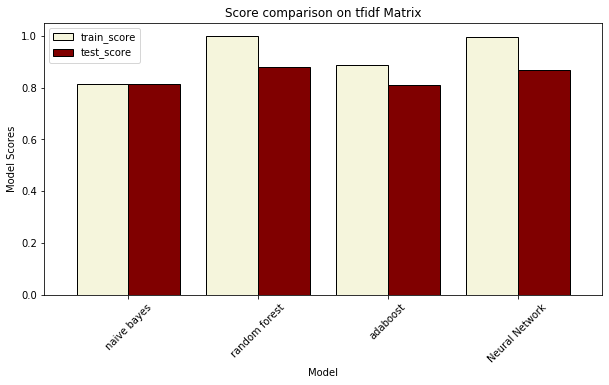

In [224]:
model_names = ['naive bayes','random forest','adaboost','Neural Network']
models = [nb_tfidf,rf_tfidf,ada_tfidf,mlp_tfidf]
tfidf_scores = pd.DataFrame(columns=["Model","train_score","test_score"])
for row in range(4):
    tfidf_scores.loc[row,"Model"] = model_names[row]
    tfidf_scores.loc[row,"train_score"] = models[row][0]
    tfidf_scores.loc[row,"test_score"] = models[row][1]

tfidf_scores.set_index('Model',inplace = True)
tfidf_scores.plot.bar(figsize=(10,5), color = ['beige','maroon'],ec = 'Black', width= 0.8)
plt.title("Score comparison on tfidf Matrix")
plt.xticks(rotation = 45)
plt.ylabel("Model Scores")
plt.show()

##### Model Building on count vector matrix

In [225]:
# naive bayes
nb_count = model_score(MultinomialNB(),vect='count')
#Random Forest
rf_count = model_score(RandomForestClassifier(),vect='count')
#adaboost
ada_count = model_score(AdaBoostClassifier(),vect='count')
#neural network
mlp_count = model_score(MLPClassifier(),vect='count')

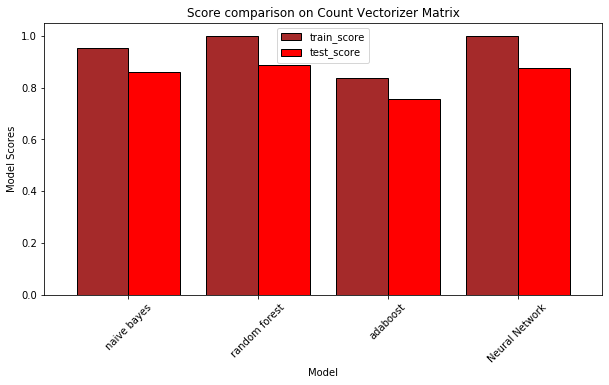

In [226]:
models = [nb_count,rf_count,ada_count,mlp_count]
count_scores = pd.DataFrame(columns=["Model","train_score","test_score"])
for row in range(4):
    count_scores.loc[row,"Model"] = model_names[row]
    count_scores.loc[row,"train_score"] = models[row][0]
    count_scores.loc[row,"test_score"] = models[row][1]

count_scores.set_index('Model',inplace = True)

count_scores.plot.bar(figsize=(10,5), color = ['brown','r'],ec = 'Black', width= 0.8)
plt.title("Score comparison on Count Vectorizer Matrix")
plt.xticks(rotation = 45)
plt.ylabel("Model Scores")
plt.show()

###### Conclusion:
* **random forest** is giving best result in both the matrix 
* lets calculate other metrics for model validation

###### extracting best model output- (save for future)

In [227]:
best_model = rf_tfidf[2]  # to get random_forest model output from the model_score udf

# save model output
joblib.dump(best_model ,"best_rf_tfidf.pkl")

['best_rf_tfidf.pkl']

In [228]:
# load model outpurt
best_model=joblib.load("best_rf_tfidf.pkl")

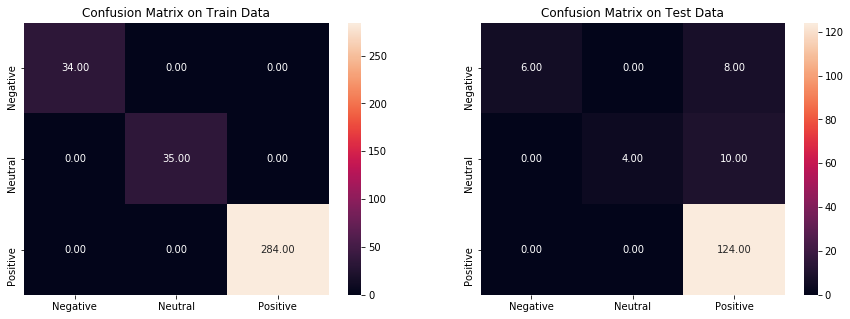

In [229]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
g1 = sns.heatmap(metrics.confusion_matrix(y_train,best_model.predict(X_train_tfidf)),annot = True, fmt='.2f', 
                 ax=ax, xticklabels=['Negative','Neutral','Positive'] , yticklabels = ['Negative','Neutral','Positive']) 
g1.set_title("Confusion Matrix on Train Data")
g2 = sns.heatmap(metrics.confusion_matrix(y_test,best_model.predict(X_test_tfidf)),annot = True, fmt='.2f', ax=ax2,
                xticklabels=['Negative','Neutral','Positive'] , yticklabels = ['Negative','Neutral','Positive'])
g2.set_title("Confusion Matrix on Test Data")
plt.show()

In [230]:
# classification report on test dataset
print(metrics.classification_report(y_test,best_model.predict(X_test_tfidf)))

              precision    recall  f1-score   support

    Negative       1.00      0.43      0.60        14
     Neutral       1.00      0.29      0.44        14
    Positive       0.87      1.00      0.93       124

    accuracy                           0.88       152
   macro avg       0.96      0.57      0.66       152
weighted avg       0.90      0.88      0.86       152



----------------------------------------------------------------------------------------------------------------------
## 3. Topic Modelling(LDA) - Identifying Key Themes 

In [171]:
# create dictionary and corpus for topic modelling
id2word = corpora.Dictionary(df.Reviews_cleaned)
corpus = [id2word.doc2bow(rev) for rev in df.Reviews_cleaned]

In [172]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


* Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id,word_frequency).
* For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs once and so on.

In [173]:
# to see the word frequency for words instead of word id 
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('great_job', 1),
  ('helped', 1),
  ('move', 1),
  ('person', 1),
  ('process', 1),
  ('professional', 1),
  ('refinance', 1),
  ('smoothly', 1),
  ('thank', 1),
  ('wyndham_capital', 1)]]

In [270]:
# to get the word_frequency table from corpus
word_dictionary = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
wrd = []
word_freq = []
for eachrow in word_dictionary:
    for tup in eachrow:
        wrd.append(tup[0])
        word_freq.append(tup[1])
        
freq_word = pd.DataFrame([wrd,word_freq]).T
freq_word.columns = ['word','freq']

##### find the best number of topics  in the LDA Model based on coherence score and perplexity of model

In [174]:
def best_LDA_model(dictionary,corpus, texts, limit, start=2, step=2):
    coherence_values = []
    perplexity_scores = []
    model_list = []
    for num_topics in range(start, limit, step):  #iterate through different number of topics 
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary , random_state=121)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_scores.append(model.log_perplexity(corpus))

    return model_list, coherence_values , perplexity_scores

In [175]:
# create different models on number of topics ranging from 2 to 50
model_list, coherence_values, perplexity_scores  = best_LDA_model(dictionary=id2word, 
                                                                            corpus=corpus, texts=df.Reviews_cleaned,
                                                                            start=2, limit=50, step=1)

###### To get the best result from LDA Model , we require the best value of num_topics which provides
* 1. low perplexity
* 2. high coherence 

Lets visualize different model results to get the desired number of topics

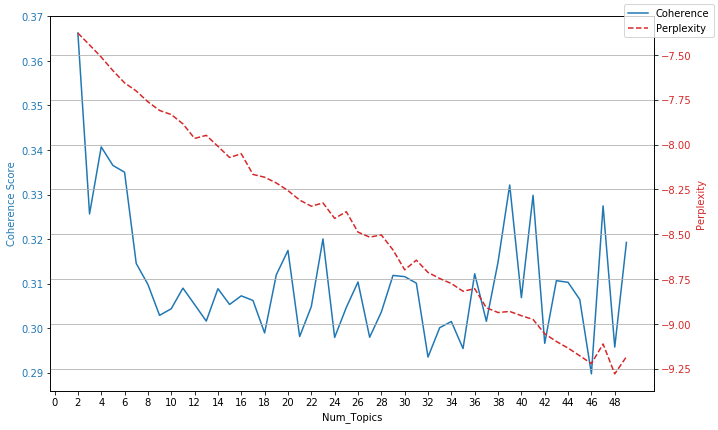

In [176]:
limit=50; start=2; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

color = 'tab:blue'
ax1.set_xlabel('Num_Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(x, coherence_values, "-",color = color, label = 'Coherence')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(0, 50, 2))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(x, perplexity_scores,"--" ,color = color, label = 'Perplexity')
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
fig.legend()
fig.tight_layout() 
plt.show()# Print the coherence scores

In [177]:
pd.DataFrame([x,coherence_values,perplexity_scores],
             index= ['Num_Topics','Cohenrence_Values','Perplexity']).T.sort_values(by='Cohenrence_Values',ascending = False).head()

,Num_Topics,Cohenrence_Values,Perplexity
0,2.0,0.366272,-7.378077
2,4.0,0.340699,-7.512269
3,5.0,0.336535,-7.587477
4,6.0,0.335013,-7.655777
37,39.0,0.332139,-8.930349


#### I choose best value of num_topics as 4

In [178]:
optimal_model = model_list[2]  # as num_topic =4 is indexed at 2

In [214]:
# save optimal model output
joblib.dump(optimal_model, "optimal_model_lda.pkl")

['optimal_model_lda.pkl']

In [215]:
## loading lda optimal model output
optimal_model_lda = joblib.load("optimal_model_lda.pkl")

In [181]:
optimal_model_lda.print_topics(num_words = 20)

[(0,
  '0.017*"loan" + 0.011*"read" + 0.010*"process" + 0.009*"mortgage" + 0.006*"nasb" + 0.006*"get" + 0.005*"recommend" + 0.005*"experience" + 0.005*"time" + 0.005*"great" + 0.005*"closing" + 0.005*"made" + 0.005*"worked" + 0.005*"refinance" + 0.004*"told" + 0.004*"call" + 0.004*"home" + 0.004*"also" + 0.004*"knowledgeable" + 0.004*"company"'),
 (1,
  '0.012*"process" + 0.010*"loan" + 0.009*"read" + 0.008*"closing" + 0.007*"made" + 0.006*"team" + 0.006*"experience" + 0.005*"time" + 0.005*"great" + 0.005*"questions" + 0.005*"rate" + 0.005*"everything" + 0.005*"work" + 0.005*"mortgage" + 0.005*"home" + 0.004*"get" + 0.004*"nasb" + 0.004*"easy" + 0.004*"always" + 0.004*"helpful"'),
 (2,
  '0.015*"loan" + 0.008*"read" + 0.008*"questions" + 0.007*"process" + 0.007*"best" + 0.007*"mortgage" + 0.007*"time" + 0.006*"work" + 0.006*"recommend" + 0.006*"team" + 0.005*"worked" + 0.005*"home" + 0.005*"get" + 0.005*"adam" + 0.005*"refinance" + 0.005*"professional" + 0.004*"made" + 0.004*"loan_offi

In [182]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model_lda, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.011922  0.044377       1        1  32.284744
1      0.023177 -0.025565       2        1  25.214466
2     -0.050030 -0.005301       3        1  22.541134
0      0.014931 -0.013511       4        1  19.959658, topic_info=             Term        Freq       Total Category  logprob  loglift
29           loan  214.000000  214.000000  Default  30.0000  30.0000
593          adam   28.000000   28.000000  Default  29.0000  29.0000
15       mortgage  101.000000  101.000000  Default  28.0000  28.0000
417        worked   58.000000   58.000000  Default  27.0000  27.0000
6       refinance   56.000000   56.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
240          work   11.867863   83.851517   Topic4  -5.6792  -0.3438
42           team   11.575964   85.846298   Topic4  -5.7041  -0.3922
150           one    9.593664   42.936691   Topic4  -5.8920   0.1128
5    professional   10.221028   61.071781   Topic4  -5.8286  -0.1761
312          rate    9.697689   56.107788   Topic4  -5.8812  -0.1439

[347 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
428       1  0.556005    aaron
428       2  0.101092    aaron
428       3  0.252730    aaron
428       4  0.101092    aaron
593       1  0.070062     adam
...     ...       ...      ...
639       2  0.726622  written
484       1  0.224386    years
484       2  0.373976    years
484       3  0.224386    years
484       4  0.199454    years

[663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

###### dominant topic in each document 

In [183]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [184]:
df_dominant_Topic = format_topics_sentences(ldamodel=optimal_model_lda,corpus=corpus,texts=df.Reviews_cleaned)
df_dominant_Topic

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Reviews_cleaned
0,3.0,0.9269,"process, time, read, loan, home, great, always...","[great_job, wyndham_capital, person, professio..."
1,0.0,0.6239,"loan, read, process, mortgage, nasb, get, reco...","[matthew, richardson, professional, helpful, h..."
2,1.0,0.6146,"process, loan, read, closing, made, team, expe...","[past, experience, wyndham, mortgage, without,..."
3,1.0,0.8777,"process, loan, read, closing, made, team, expe...","[dealing, brad, thomka, beginning, started, st..."
4,3.0,0.9676,"process, time, read, loan, home, great, always...","[cant, express, grateful, support, zach, provi..."
...,...,...,...,...
500,0.0,0.5923,"loan, read, process, mortgage, nasb, get, reco...","[never, write, reviews, time, prevent, anyone,..."
501,0.0,0.6822,"loan, read, process, mortgage, nasb, get, reco...","[started, bob, ran, credit, check, without, kn..."
502,1.0,0.8833,"process, loan, read, closing, made, team, expe...","[horrible, experience, excellent, credit, plen..."
503,1.0,0.9922,"process, loan, read, closing, made, team, expe...","[rep, extremely, professional, friendly, helpf..."


---------------------------------------------------------------------------------------------------------------------------------------------
## 4. Predicting Star Rating

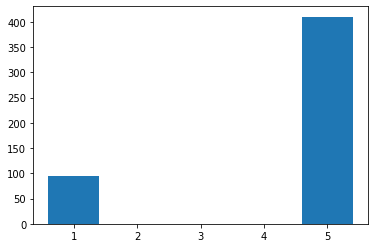

In [186]:
plt.bar(df.Stars.value_counts().index,df.Stars.value_counts())
plt.show()

* Stars are given only as 1 or 5  hence we can perform binomial classification 
* lets create new target variable as 'five_star_rating' where five_star_rating == 5 is 1 & five_star_rating == 1 is 0

In [231]:
df['five_star_rating'] = np.where(df.Stars == 1 , 0,
                                  np.where(df.Stars == 5 , 1, np.nan))
df.five_star_rating = df.five_star_rating.astype('int64')

In [232]:
df.five_star_rating.value_counts()

1    410
0     95
Name: five_star_rating, dtype: int64

In [233]:
# define five_star_rating column as target variable , Reviews column as X 
X = df.Reviews_cleaned.apply(convert_totext)

y = df.five_star_rating  # binary variable

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 ,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(353,)
(152,)
(353,)
(152,)


###### feature creation through vectorizers

In [234]:
#Train
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(X_train)
#test
X_test_tfidf = tfidf_vect.transform(X_test)
X_test_count = count_vect.transform(X_test)
dtm_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
dtm_count = pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())

###### model building on tfidf matrix
**_Note_** : _following modelling will be done using 'model_score' function created earlier_

In [235]:
# naive bayes
nb_tfidf = model_score(MultinomialNB(),vect='tfidf')
#Random Forest
rf_tfidf = model_score(RandomForestClassifier())
#adaboost
ada_tfidf = model_score(AdaBoostClassifier())
#neural network
mlp_tfidf = model_score(MLPClassifier())

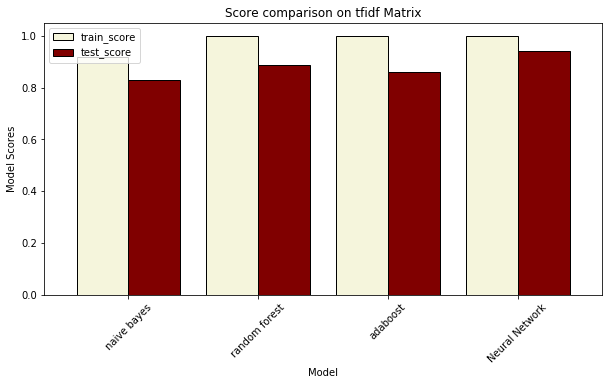

In [236]:
model_names = ['naive bayes','random forest','adaboost','Neural Network']
models = [nb_tfidf,rf_tfidf,ada_tfidf,mlp_tfidf]
tfidf_scores = pd.DataFrame(columns=["Model","train_score","test_score"])
for row in range(4):
    tfidf_scores.loc[row,"Model"] = model_names[row]
    tfidf_scores.loc[row,"train_score"] = models[row][0]
    tfidf_scores.loc[row,"test_score"] = models[row][1]

tfidf_scores.set_index('Model',inplace = True)
tfidf_scores.plot.bar(figsize=(10,5), color = ['beige','maroon'],ec = 'Black', width= 0.8)
plt.title("Score comparison on tfidf Matrix")
plt.xticks(rotation = 45)
plt.ylabel("Model Scores")
plt.show()

In [237]:
tfidf_scores

,train_score,test_score
Model,,
naive bayes,0.917847,0.828947
random forest,1,0.888158
adaboost,1,0.861842
Neural Network,1,0.940789


* **MLP classifier** is giving the best test score on tfidf term matrix

###### model building on count  vectorizer matrix

In [238]:
# naive bayes
nb_count = model_score(MultinomialNB(),vect='count')
#Random Forest
rf_count = model_score(RandomForestClassifier(),vect='count')
#adaboost
ada_count = model_score(AdaBoostClassifier(),vect='count')
#neural network
mlp_count = model_score(MLPClassifier(),vect='count')

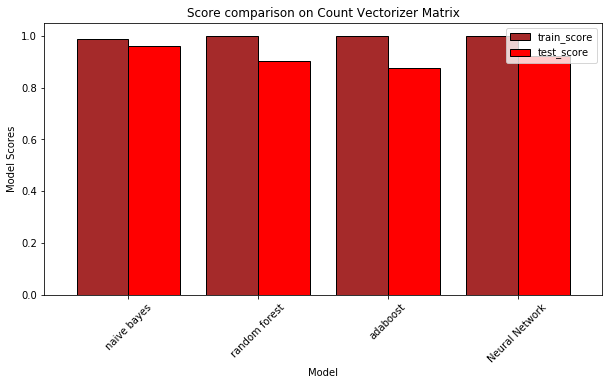

In [239]:
models = [nb_count,rf_count,ada_count,mlp_count]
count_scores = pd.DataFrame(columns=["Model","train_score","test_score"])
for row in range(4):
    count_scores.loc[row,"Model"] = model_names[row]
    count_scores.loc[row,"train_score"] = models[row][0]
    count_scores.loc[row,"test_score"] = models[row][1]

count_scores.set_index('Model',inplace = True)

count_scores.plot.bar(figsize=(10,5), color = ['brown','r'],ec = 'Black', width= 0.8)
plt.title("Score comparison on Count Vectorizer Matrix")
plt.xticks(rotation = 45)
plt.ylabel("Model Scores")
plt.show()

In [240]:
count_scores

,train_score,test_score
Model,,
naive bayes,0.988669,0.960526
random forest,1,0.901316
adaboost,1,0.875
Neural Network,1,0.921053


* **naive bayes** classifier is giving best test results on count vector matrix

###### Define Optimal Model(save for later)

In [241]:
# extracting optimal model from above results 

optimal_model_starrating = nb_count[2] # index [2] to get the model output from the model_score results

# saving model output
joblib.dump(optimal_model_starrating,"optimal_model_starrating.pkl")

['optimal_model_starrating.pkl']

In [242]:
# loading best model for star rating classification
optimal_model_starrating = joblib.load("optimal_model_starrating.pkl")

#### Model Validation

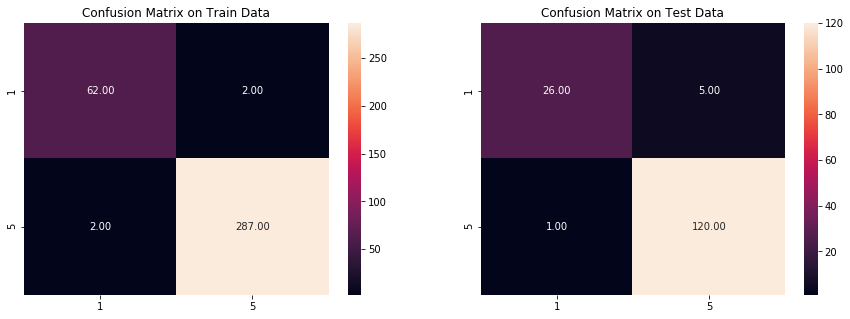

In [199]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
g1 = sns.heatmap(metrics.confusion_matrix(y_train,optimal_model_starrating.predict(X_train_count)),annot = True, fmt='.2f', 
                 ax=ax, xticklabels=[1,5] , yticklabels = [1,5]) 
g1.set_title("Confusion Matrix on Train Data")
g2 = sns.heatmap(metrics.confusion_matrix(y_test,optimal_model_starrating.predict(X_test_count)),annot = True, fmt='.2f', ax=ax2,
                xticklabels=[1,5] , yticklabels = [1,5])
g2.set_title("Confusion Matrix on Test Data")
plt.show()

In [200]:
# classification report on train dataset
print(metrics.classification_report(y_train,optimal_model_starrating.predict(X_train_count)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        64
           1       0.99      0.99      0.99       289

    accuracy                           0.99       353
   macro avg       0.98      0.98      0.98       353
weighted avg       0.99      0.99      0.99       353



In [201]:
# classification report on test dataset
print(metrics.classification_report(y_test,optimal_model_starrating.predict(X_test_count)))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.96      0.99      0.98       121

    accuracy                           0.96       152
   macro avg       0.96      0.92      0.94       152
weighted avg       0.96      0.96      0.96       152



###### top words in Reviews which contributes more in classifying star rating as 5 or 1

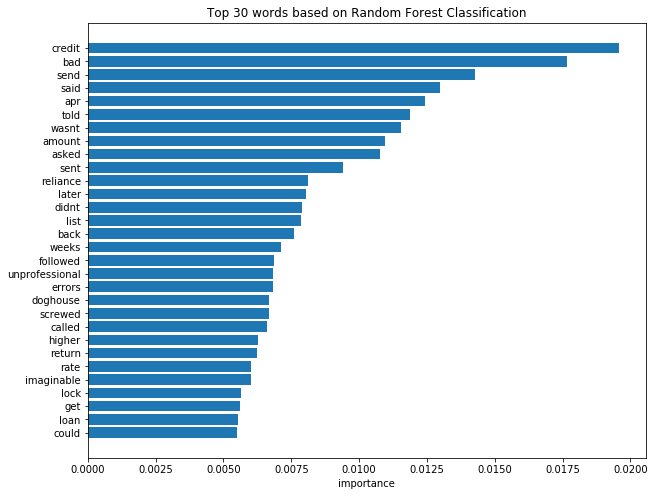

In [202]:
Feature_importance = pd.DataFrame([x for x in zip(dtm_count.columns , rf_count[2].feature_importances_)], 
                                  columns= ['features','importance']).sort_values(by = 'importance',ascending = True)

#displaying top 30 words based on importance
plt.figure(figsize = (10,8))
plt.title("Top 30 words based on Random Forest Classification")
plt.barh(Feature_importance.features.tail(30),Feature_importance.importance.tail(30))
plt.xlabel("importance")
plt.show()

------------------------------------------------------------------------------
##### --------------------------------------------------------The End ----------------------------------------------------------

In [213]:
# exporting final dataset output
df.to_csv("final_dataset.csv")
df_dominant_Topic.to_csv("Dominant_Topic_per_document.csv")

In [271]:
# exporting word_frequency table based on which LDA model was built
freq_word.to_csv("freq_word_corpus.csv")